# DIP - Dependency Inversion Principle

Powinniśmy programować za pomocą abstrakcji, nie implementacji. Implementacje mogą się zmieniać, abstrakcje nie powinny​

**Moduły wysokopoziomowe nie powinny zależeć od niskopoziomowych. Obie powinny zależeć od abstrakcji.**

Prościej: Zależności wskazuj od abstrakcji (interfejsów), nie od konkretnych implementacji.

## Złe rozwiązanie - łamie DIP

System wysyłania powiadomień.

In [19]:
# Niskopoziomowy moduł - konkretna implementacja
class EmailService:
    def send_email(self, message):
        print(f"Email wysłany: {message}")


In [20]:
# Wysokopoziomowy moduł - logika biznesowa
class NotificationService:
    def __init__(self):
        self.email = EmailService()  # ← Zależność od IMPLEMENTACJI
    
    def notify(self, message):
        self.email.send_email(message)  # ← Sztywne powiązanie


In [21]:
# client code
notifier = NotificationService()
notifier.notify("Zamówienie wysłane")

Email wysłany: Zamówienie wysłane


### Problem:

Chcesz dodać SMS? Musisz **EDYTOWAĆ** `NotificationService`:

```python
class NotificationService:
    def __init__(self, use_sms=False):  # ← Edycja
        if use_sms:
            self.service = SMSService()  # ← Nowa zależność
        else:
            self.service = EmailService()
```

**Problem:** `NotificationService` jest **sztywno sprzężony** z konkretnymi klasami (`EmailService`, `SMSService`).

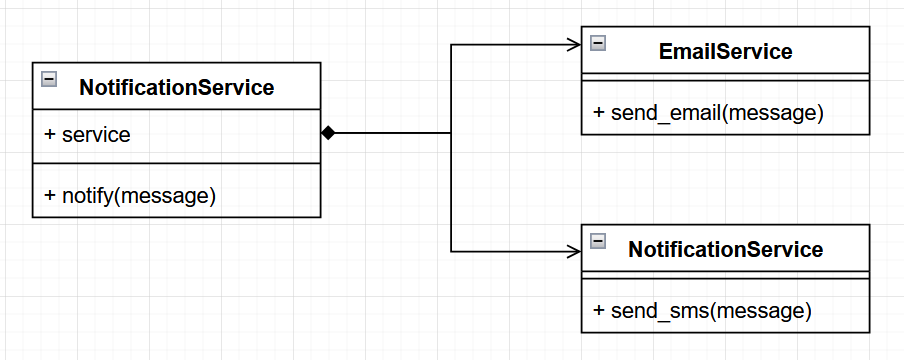

## Dobre rozwiązanie - zgodne z DIP

Zależność od **abstrakcji**, nie od konkretnych klas.

In [11]:
# TODO: Interfejs + implementacje
from abc import ABC, abstractmethod

class MessageSender(ABC):
    @abstractmethod
    def send(self, message):
        ...


class EmailSender(MessageSender):
    def send(self, message):
        print(f"Email wysłany: {message}")


class SMSSender(MessageSender):
    def send(self, message):
        print(f"SMS wysłany: {message}")

In [12]:
# TODO: wysokopoziomowy moduł
class NotificationService:
    def __init__(self, sender: MessageSender):
        self.sender = sender

    def notify(self, message):
        self.sender.send(message)

In [13]:
# client code
# email
email_sender = EmailSender()
email_notifier = NotificationService(email_sender)
email_notifier.notify("Zamówienie wysłane")

# sms (bez edycji NotificationService!)
sms_notifier = NotificationService(SMSSender())
sms_notifier.notify("Zamówienie wysłane")

Email wysłany: Zamówienie wysłane
SMS wysłany: Zamówienie wysłane


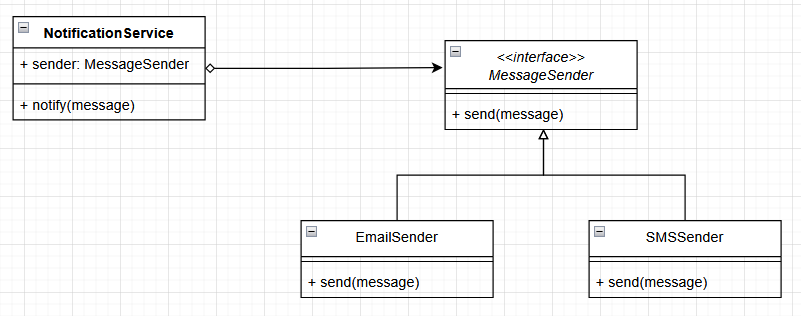

### Dodanie nowego kanału - zero edycji!

In [25]:
# Nowy kanał - Slack (NOWA KLASA, NotificationService bez zmian)
class SlackSender(MessageSender):
    def send(self, message):
        print(f"Slack wysłany: {message}")


In [26]:
# Użycie - NotificationService NIE ZMIENIONY!
slack_notifier = NotificationService(SlackSender())
slack_notifier.notify("Zamówienie wysłane")

Slack wysłany: Zamówienie wysłane


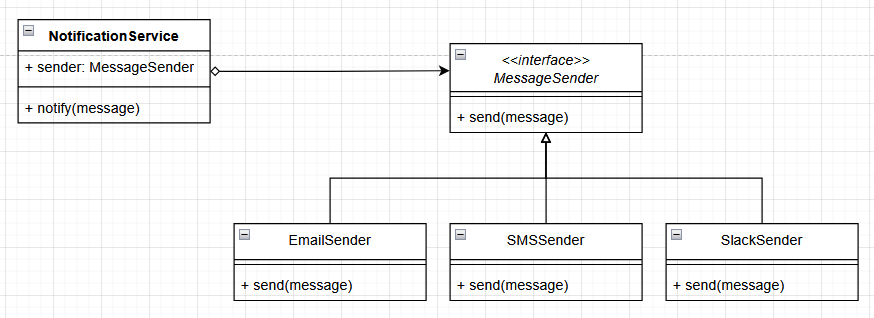

**Kluczowa zmiana:** Obie klasy (wysokopoziomowa i niskopoziomowa) zależą od **abstrakcji**.

## Porównanie

| Aspekt | Złe (konkretna klasa) | Dobre (interfejs) |
|--------|--------------------------|----------------------|
| Zależność | `EmailService` (implementacja) | `MessageSender` (abstrakcja) |
| Nowy kanał | Edytuj `NotificationService` | Nowa klasa, zero edycji |
| Testowanie | Trudne (prawdziwy email) | Łatwe (mock sender) |
| Sprzężenie | Silne | Luźne |
| Elastyczność | Niska | Wysoka |

## Bonus: Łatwiejsze testowanie

Dependency injection potrafi znacznie ułatwić testowanie. 

In [17]:
# Mock dla testów
class MockSender(MessageSender):
    def __init__(self):
        self.messages = []
    
    def send(self, message):
        self.messages.append(message)
        print(f"Test: zapisano '{message}'")


In [18]:
# Test jednostkowy
mock = MockSender()
test_notifier = NotificationService(mock)
test_notifier.notify("Test message")

# Asercja
assert len(mock.messages) == 1
assert mock.messages[0] == "Test message"
print("Test passed!")

Test: zapisano 'Test message'
Test passed!


## Jak rozpoznać łamanie DIP?

### Złe sygnały:
```python
class HighLevel:
    def __init__(self):
        self.service = ConcreteClass()  # ← tworzy konkretną klasę
```

### Dobre sygnały:
```python
class HighLevel:
    def __init__(self, service: AbstractClass):  # ← przyjmuje interfejs, dependency injection
        self.service = service
```

**Pytanie testowe:** Czy mogę łatwo podmienić implementację bez edycji `HighLevel`?  
- NIE → łamiesz DIP
- TAK → zgodne z DIP

## Podsumowanie

### DIP w jednym zdaniu:
**Zależności wskazuj od interfejsów, nie od konkretnych klas.**

### Jak stosować DIP?
1. Zdefiniuj interfejs (klasę abstrakcyjną)
2. Implementacje dziedziczą po interfejsie
3. Klasa wysokopoziomowa przyjmuje interfejs w konstruktorze (dependency injection)

### Korzyści:
- Luźne sprzężenie
- Łatwe testowanie (mock objects)
- Elastyczność - zmiana implementacji bez edycji kodu
- Zgodność z OCP (Open/Closed Principle)

### DIP ≠ Dependency Injection
- **DIP** = zasada projektowania (zależności od abstrakcji)
- **Dependency Injection** = technika (wstrzykiwanie przez konstruktor/setter)